# 필요한 거 불러오고

In [109]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

# 파일 불러와줌

In [110]:

# 파라미터
MIN_DIST = 3.0  # 최소 점 간 거리
IMG_PATH = "./data/test3.jpg"

# 이미지 불러오기 및 전처리
image = cv2.imread(IMG_PATH)
if image is None:
    raise FileNotFoundError("이미지를 찾을 수 없습니다.")

# 전처리
레츠기릿

In [111]:
bilateral = cv2.bilateralFilter(image, 9, 75, 75)
gray = cv2.cvtColor(bilateral, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150)

- cv2.getStructuringElement(shape, ksize)
    : 모폴로지에 쓰는 커널 함수 
    - shape : 구조화 요소 모양 MORPH_CROSS = 십자가 모양
    - ksize : 커널 크기 (행, 열)

In [112]:

# Skeletonization
def skeletonize(img):
    skel = np.zeros(img.shape, np.uint8) # 빈 이미지 생성 (0으로 채워진)
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    while True:
        open_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
        temp = cv2.subtract(img, open_img)
        eroded = cv2.erode(img, element)
        skel = cv2.bitwise_or(skel, temp)
        img[:] = eroded[:]
        if cv2.countNonZero(img) == 0:
            break
    return skel

skeleton = skeletonize(edges)

In [113]:
# (y, x) 좌표 추출
points = np.column_stack(np.where(skeleton > 0))
print("포인트 데이터 구조 -> ", points.shape)
print("포인트 데이터 -> ", points[:5])  # 처음 5개 포인트 출력
visited = np.zeros(len(points), dtype=bool) # zeros니까 전부 False로 초기화된 상태 
path = []

포인트 데이터 구조 ->  (3332, 2)
포인트 데이터 ->  [[ 40 165]
 [ 40 166]
 [ 40 167]
 [ 40 168]
 [ 40 169]]


In [114]:
# 시작점: 가장 왼쪽 위 점
current_idx = np.argmin(points[:, 0] + points[:, 1])
print("시작점 인덱스 -> ", current_idx)
current_point = points[current_idx]
print(current_point)
visited[current_idx] = True
path.append(tuple(current_point))


시작점 인덱스 ->  149
[ 62 116]


In [115]:
# 저걸 왜 더하는데
# temp_p = np.array([[40, 165],
#  [40, 166],
#  [40, 167],
#  [40, 168],
#  [40, 169]])
# print("포인트 데이터 구조 -> ", temp_p.shape)
# print(
#     temp_p[:, 0] + temp_p[:, 1]
# )
# np.argmax(temp_p[:, 0] + temp_p[:, 1]) # 0

In [116]:
temp_array = np.array([False, True, False, False, True])
print(np.where(~temp_array))
print(np.where(~temp_array)[0])  # False인 인덱스

(array([0, 2, 3], dtype=int64),)
[0 2 3]


In [117]:

# TSP-like 연결 (가장 가까운 점 찾기)
while not np.all(visited): # visited가 모두 True가 될 때까지 반복
    dists = distance.cdist([current_point], points[~visited]) # 아직 방문하지 않은 점들과의 거리를 모두 계산 / ~ = not 즉, visited가 False점들
    
    print(dists)
    # dist shape = (1, 점개수)
    # print("==========")
    # print(dists.shape)
    nearest_idx_in_unvisited = np.argmin(dists)
    global_idx = np.where(~visited)[0][nearest_idx_in_unvisited]
    # print(nearest_idx_in_unvisited, global_idx)  
    if dists[0, nearest_idx_in_unvisited] < MIN_DIST:
        visited[global_idx] = True
        continue  # 너무 가까우면 스킵
    current_point = points[global_idx]
    visited[global_idx] = True
    path.append(tuple(current_point))
    # break


[[ 53.71219601  54.62600113  55.54277631 ... 418.91407233 410.17313418
  419.88808033]]
[[ 53.71219601  54.62600113  55.54277631 ... 418.91407233 410.17313418
  419.88808033]]
[[ 53.71219601  54.62600113  55.54277631 ... 418.91407233 410.17313418
  419.88808033]]
[[ 53.71219601  54.62600113  55.54277631 ... 418.91407233 410.17313418
  419.88808033]]
[[ 53.71219601  54.62600113  55.54277631 ... 418.91407233 410.17313418
  419.88808033]]
[[ 53.71219601  54.62600113  55.54277631 ... 418.91407233 410.17313418
  419.88808033]]
[[ 53.71219601  54.62600113  55.54277631 ... 418.91407233 410.17313418
  419.88808033]]
[[ 53.71219601  54.62600113  55.54277631 ... 418.91407233 410.17313418
  419.88808033]]
[[ 50.56678752  51.4781507   52.39274759 ... 419.2195129  410.95498537
  420.19519274]]
[[ 50.56678752  51.4781507   52.39274759 ... 419.2195129  410.95498537
  420.19519274]]
[[ 50.56678752  51.4781507   52.39274759 ... 419.2195129  410.95498537
  420.19519274]]
[[ 50.56678752  51.4781507   52.

KeyboardInterrupt: 

가장 가까운 점 방문하면서 연결

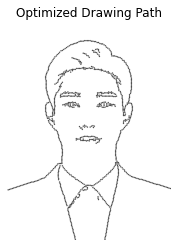

In [ ]:
# 결과 이미지 생성
draw_img = np.ones_like(image) * 255
for pt in path:
    cv2.circle(draw_img, (pt[1], pt[0]), 1, (0, 0, 0), -1)

# 저장 및 확인
# cv2.imwrite("path_thinned.png", draw_img)
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
plt.title("Optimized Drawing Path")
plt.axis("off")
plt.show()


밑에 코드는 알고 싶지 않다...  
호호

In [ ]:

#############################
# path를 여러 개의 선으로 나누고, turtle로 뗐다 붙였다 그리는 버전
import turtle

# 거리 기준 (너무 멀면 새 선으로 인식)
BREAK_DIST = 15.0

# path를 여러 선으로 분할
def split_path_into_lines(path, break_dist=15.0):
    lines = []
    current_line = [path[0]]
    for prev, curr in zip(path[:-1], path[1:]):
        dist = np.linalg.norm(np.array(curr) - np.array(prev))
        if dist > break_dist:
            if len(current_line) > 1:
                lines.append(current_line)
            current_line = [curr]
        else:
            current_line.append(curr)
    if len(current_line) > 1:
        lines.append(current_line)
    return lines

# 좌표 변환용
h, w = 600, 800
scale_x = 800 / w
scale_y = 600 / h

# Turtle 설정
turtle.speed(0)
turtle.bgcolor("white")
turtle.pensize(1)
screen = turtle.Screen()
screen.setup(width=800, height=600)
colors = ["black", "red", "blue", "green", "purple", "orange"]

# 선 분할
lines = split_path_into_lines(path)

# 그리기
for idx, line in enumerate(lines):
    if len(line) == 0:
        continue
    turtle.penup()
    y, x = line[0]
    turtle.goto(x * scale_x - 400, 300 - y * scale_y)
    turtle.pencolor(colors[idx % len(colors)])
    turtle.pendown()
    for y, x in line[1:]:
        turtle.goto(x * scale_x - 400, 300 - y * scale_y)

turtle.done()

Terminator: 